<h1>
<center>
Mestrado em Bioinformática
</center>
</h1>

<h2>
<center>
Text Mining project pipeline
</center>
</h2>

<center>José Pedro Silva Freitas, PG42872
<center>pg42872@alunos.uminho.pt

<font size="+2">This is bigger text.</font>

<font size="-2">This is smaller text.</font>

jupyter-nbconvert --to PDFviaHTML test.ipynb

<p>
O presente documento tem engloba uma representação mais organizada da
pipeline que foi realizada de modo a solucionar os problemas previstos
para a realização deste projeto. <br>
Como já referenciado no artigo, este projeto teve como principal objetivo
a mineração de textos biomédicos de forma a encontrar referências acerca
do metabolismo secundário de plantas, mais especificamente, na via metabólica
relacionada com o composto resveratrol, de forma a facilitar o estudo deste
tipo de metabolismo, assim como a sua interferência no fenótipo das plantas
</p>

In [11]:
"""Imports"""

import tensorflow
import pandas
# import numpy as np
# from Bio.Entrez import efetch, read
from Bio import Entrez
import os
import sys
from web_pubmed_reader import get_data_from_pmid, \
    term_to_docs_all, pmids_to_docs
from dl_config import DLConfig
from wrappers.pandas_wrapper import docs_to_pandasdocs
# pandasframe_trimming,
# search_keyword_pandasframe
import string
from stop_words import get_stop_words

<p>
Como base para esta pipeline, foi usada uma ferramente já disponível,
<a href="https://gitlab.bio.di.uminho.pt/biotextminingpy/biotmpy/-/tree/master/preprocessing"><strong>BioTMPy</strong></a>,
e que foi desenvolvida com um propósito relativamente idêntico, a partir da qual
se pode retirar algumas ilações. <br>
Os módulos deste pacote incluem classes e funções que permitem a extração de
documentos e artigos presentes em bases de dados, neste caso do PubMed,
através do package <strong>Biopython</strong>, mais especificamente, o
package <strong>Bio.Entrez</strong>.
</p>


In [17]:
keywordlst = ["resveratrol",
              "resveratrol synthase",
              "stilbene synthase",
              "trihydroxystilbene",
              "p-coumaroyl-CoA",
              "viniferin",
              "piceatannol",
              "piceid",
              "pterostilbene",
              "pinostilbene",
              "chalcone resveratrol"]


def get_number_articles_per_term(term, email):
    Entrez.email = email
    Entrez.api_key = '0a925fca3ee9689bd778607f10e438fbfa09'
    search_results = Entrez.read(Entrez.esearch(db="pubmed", term=term))
    records = search_results["Count"]
    return int(records)


for keyword in keywordlst:
    print("Número de artigos encontrados para a keyword", keyword+":",
      get_number_articles_per_term(keyword, "pg42872@alunos.uminho.pt"))

Número de artigos encontrados para a keyword resveratrol: 14485
Número de artigos encontrados para a keyword resveratrol synthase: 52
Número de artigos encontrados para a keyword stilbene synthase: 287
Número de artigos encontrados para a keyword trihydroxystilbene: 542
Número de artigos encontrados para a keyword p-coumaroyl-CoA: 109
Número de artigos encontrados para a keyword viniferin: 319
Número de artigos encontrados para a keyword piceatannol: 839
Número de artigos encontrados para a keyword piceid: 721
Número de artigos encontrados para a keyword pterostilbene: 638
Número de artigos encontrados para a keyword pinostilbene: 35
Número de artigos encontrados para a keyword chalcone resveratrol: 68


<p>
Foi desenvolvida uma nova função - <i>get_all_data_from_term</i> - que suportasse
não um número máximo de artigos definido pelo utilizador, mas sim o número máximo
de artigos para um dado termo, isto sabendo que a função do <strong>Bio.Entrez</strong>
tem um rate máximo de extração de cerca de 100000 ID's por cada iteração, e para
prevenir os casos em que o número de artigos ultrapassa este threshold.
</p>

In [19]:
def get_all_data_from_term(term, email):
    Entrez.email = email
    Entrez.api_key = '0a925fca3ee9689bd778607f10e438fbfa09'
    retmax = get_number_articles_per_term(term, email)
    records = []
    ub = 100000  # número máximo de artigos que a função esearch consegue capturar
    if retmax > ub:
        for startpos in range(0, retmax, ub):
            handle = Entrez.esearch(db="pubmed", retstart=startpos, retmax=ub, term=term, idtype="acc",
                                    sort="relevance")
            record = Entrez.read(handle)
            records.append(record)  # pode-se dar append ao record numa lista? SIM PODE-SE
            handle.close()
    else:
        handle = Entrez.esearch(db="pubmed", retmax=retmax, term=term, idtype="acc", sort='relevance')
        record = Entrez.read(handle)
        records.append(record)
        handle.close()

    size = 0
    result = []
    if len(records) > 1:  # para o caso do numero de artigos ter sido maior que 100000
        for record in records:  # irá ter mais que um record
            size += len(record["IdList"])
            result.extend(record["IdList"])  # será uma lista de listas de IDs
        flat_lst = []  # dar flat à lista de IDs
        for lst in result:
            for elem in lst:
                flat_lst.append(elem)
        return flat_lst  # [record["IdList"] for record in records]
    else:  # para o caso que foi menos de 10000, e por isso records tem apenas uma lista
        for record in records:  # so tem 1
            result.extend(record["IdList"])
            return result


for keyword in keywordlst:
    print("Lista de ID's encontrados para a keyword",keyword+":",
          get_all_data_from_term(keyword, "pg42872@alunos.uminho.pt")[:20])

Lista de ID's encontrados para a keyword resveratrol: ['33691210', '33550599', '34066865', '34064568', '33781770', '33229156', '33712142', '33675782', '33675348', '33631244', '33922475', '33471184', '33946456', '33921192', '33388350', '33802331', '33103284', '33518308', '33669559', '33561994']
Lista de ID's encontrados para a keyword resveratrol synthase: ['26302213', '33444365', '25007571', '24427944', '21717185', '21932029', '11804335', '32733034', '32664999', '9225853', '2450022', '26344106', '25764453', '26092168', '25873669', '25683151', '17571969', '29138972', '24196732', '33614263']
Lista de ID's encontrados para a keyword stilbene synthase: ['30611873', '31699028', '29589146', '31531782', '29372791', '24246671', '28168876', '27702992', '31925968', '32456002', '28332216', '28214727', '26048582', '25402946', '29529275', '30445464', '28181620', '25726587', '21843947', '26781778']
Lista de ID's encontrados para a keyword trihydroxystilbene: ['27882602', '33915131', '28672886', '261

<p>
Com os PMID's de cada artigo do PubMed, o próximo objetivo será retirar o texto
disponível nesses artigos, que serão os <strong>títulos</strong> e <strong>
abstracts</strong> (resumos). A função <i>get_data_from_pmid</i> permite fazer
exatamente esse processo, devolvendo um dicionário com duas keys e os dois values
correspondentes na forma de string, procurando estes elementos em alguns dos
difentes formatos que a função <i>entrez.efetch</i> retorna.
</p>

In [20]:
resvid = get_all_data_from_term("resveratrol", "pg42872@alunos.uminho.pt")
print(resvid[0])
# Exemplo do output para o primeiro artigo encontrado referente ao resveratrol
get_data_from_pmid(resvid[0], "pg42872@alunos.uminho.pt")

33691210


{'Title': 'Development of novel functional snacks containing nano-encapsulated resveratrol with anti-diabetic, anti-obesity and antioxidant properties.',
 'Abstract': 'In this study, functional snacks with addition of nanoenapsuated resveratrol were prepared to evaluate the nutraceutical and physical properties. The nanoencapsulated resveratrol was prepared from horse-chestnut (HRP), water-chestnut (WRP) and lotus-stem starch particles (LRP) and added to the wheat flour at the level of 0.4% for preparation of snacks by extrusing process. After extrusion, 43-53% and 5.42% of resveratrol was retained in snacks containing encapsulated and free resveratrol (FRP), respectively. The HRP, WRP and LRP showed significantly less peak viscosities and less elastic behaviour than native product (NP) which can influence the human sensory perception. The shift of few peaks towards higher wavelength and presence of additional peaks at 1384, 1229, 1513 and 1613\xa0cm<sup>-1</sup> depicts change in mole

<p>
Posto isto, o módulo Document com a classe document permite analisar e transformar
as strings retiradas da função anterior, e a função <i>pmids_to_docs</i> devolve um
objeto document por cada PMID fornecido.
</p>
<p>
Esta função necessita de um argumento adicional - <strong> dl_config </strong> - o
qual representa uma classe criada à prori e que irá determinar o método de
processamento dos documentos ao gosto do utilizador.
</p>

In [21]:
dl = DLConfig()
# Exemplo do output para alguns dos artigos encontrado referente ao resveratrol
resvdoc = pmids_to_docs(resvid[0:20], "pg42872@alunos.uminho.pt", dl)
print(resvdoc)
print(len(resvdoc[0]))

([<data_structures.document.Document object at 0x000001E68CDDFEE0>, <data_structures.document.Document object at 0x000001E68EA03040>, <data_structures.document.Document object at 0x000001E68E9F72E0>, <data_structures.document.Document object at 0x000001E68E8AE0D0>, <data_structures.document.Document object at 0x000001E68EBBA7F0>, <data_structures.document.Document object at 0x000001E68EB39820>, <data_structures.document.Document object at 0x000001E68E9EC160>, <data_structures.document.Document object at 0x000001E68E835280>, <data_structures.document.Document object at 0x000001E68ED53BE0>, <data_structures.document.Document object at 0x000001E68EE5DD00>, <data_structures.document.Document object at 0x000001E68ED93910>, <data_structures.document.Document object at 0x000001E68E8A0EE0>, <data_structures.document.Document object at 0x000001E68ED413D0>, <data_structures.document.Document object at 0x000001E68E9300D0>, <data_structures.document.Document object at 0x000001E68E92D400>, <data_st

<p>
Cada objeto Document pode ser analisado de acordo com o seu título, abstract, tokens,
etc. A partir destes objetos será agora possível gerar um dataset com a estrutura
desejadas, podendo conter apenas os objetos correspondentes a cada PMID (artigo) ou
contendo já os textos de cada um.
</p>
<p>
O próximo objetivo passará ainda por obter todos os documentos já processados para
todas as keyword sugeridas a cima........ Para facilitar o processo, e mais uma vez,
como o objetivo será retirar <strong> todos </strong> os documentos disponíveis na
base de dados, e para não haver a necessidade de passar o número total de documento
aí existentes para as determinadas keywords, foi efetuada uma pequena alteração na
função <i>term_to_docs</i>, para assim deixar de depender do argumento <i> ret_max </i>.
Esta função passa assim a utilizar outra função criada anteriormente
(<i>get_all_data_from_term()</i>) para retornar todos os PMIDs, e posteriormente gerar
os objetos Document.
</p>

In [5]:
resvdocs = term_to_docs_all("resveratrol", "pg42872@alunos.uminho.pt", dl)
resvsyntdocs = term_to_docs_all("resveratrol synthase", "pg42872@alunos.uminho.pt", dl)
stilbsyntdocs = term_to_docs_all("stilbene synthase", "pg42872@alunos.uminho.pt", dl)
trihydrostilbdocs = term_to_docs_all("trihydroxystilbene", "pg42872@alunos.uminho.pt", dl)
pcouCoAdocs = term_to_docs_all("p-coumaroyl-CoA", "pg42872@alunos.uminho.pt", dl)
vinidocs = term_to_docs_all("viniferin", "pg42872@alunos.uminho.pt", dl)
piceadocs = term_to_docs_all("piceatannol", "pg42872@alunos.uminho.pt", dl)
piddocs = term_to_docs_all("piceid", "pg42872@alunos.uminho.pt", dl)
pterodocs = term_to_docs_all("pterostilbene", "pg42872@alunos.uminho.pt", dl)
pinosdocs = term_to_docs_all("pinostilbene", "pg42872@alunos.uminho.pt", dl)
caldocs = term_to_docs_all("chalcone resveratrol", "pg42872@alunos.uminho.pt", dl)

<p>
Estando agora na posse dos objetos Document podemos passar para a criação dos primeiros
datasets, nesta primeira instância, de um dataset para cada keyword.
</p>
<p>
Tendo em conta o objetivo deste trabalho e para facilitar vizualização, foi decidico
montar um dataset onde fosse possível observar os Títulos e os Abstracts de cada
documento, assim como o seu PMID e ainda a keyword através da qual foi encontrado.
</p>
<p>
O módulo <strong> pandas </strong> permite criar com facilidade <strong> DataFrames
</strong> com diversos formatos e através de diferentes métodos. Uma nova função foi
por essa razão criada com o nome de <i> docs_to_pandasdocs_idtitabs() </i> onde o
utilizador deve passar uma lista de objetos Document previamente criada, assim como
a keyword a partir da qual essa lista for criada, sob a forma de string.
</p>
<p>
Sendo assim foram criados os 11 datasets correspondentes às keywords utilizadas:
</p>

In [57]:
def docs_to_pandasdocs_idtitabs(docs, keyword):
    doc_id = []
    titles = []
    abstracts = []
    for d in docs:  # são objeto Document
        doc_id.append(d.id)
        titles.append(d.title_string)  # lista de strings
        abstracts.append(d.abstract_string)  # lista de strings
    dicionario = {"Keyword": [keyword]*len(docs),
                  "Document": doc_id,
                  "Title": titles,
                  "Abstract": abstracts}  # será um dicionário onde os values serão uma lista de strings
    df = pandas.DataFrame(dicionario)
    df = pandas.DataFrame(data=df.values, columns=list(df.columns))
    # return titles, abstracts, doc_id
    return df


resv_df = docs_to_pandasdocs_idtitabs(resvdocs, "resveratrol")
resvsynt_df = docs_to_pandasdocs_idtitabs(resvsyntdocs, "resveratrol synthase")
stilbsynt_df = docs_to_pandasdocs_idtitabs(stilbsyntdocs, "stilbene synthase")
trihydrostilb_df = docs_to_pandasdocs_idtitabs(trihydrostilbdocs, "trihydroxystilbene")
pcouCoA_df = docs_to_pandasdocs_idtitabs(pcouCoAdocs, "p-coumaroyl-CoA")
vini_df = docs_to_pandasdocs_idtitabs(vinidocs, "viniferin")
picea_df = docs_to_pandasdocs_idtitabs(piceadocs, "piceatannol")
pid_df = docs_to_pandasdocs_idtitabs(piddocs, "piceid")
ptero_df = docs_to_pandasdocs_idtitabs(pterodocs, "pterostilbene")
pinos_df = docs_to_pandasdocs_idtitabs(pinosdocs, "pinostilbene")
cal_df = docs_to_pandasdocs_idtitabs(caldocs, "chalcone resveratrol")

<p>
O DataFrame global terá que ser criado através da concatenação dos diferentes datasets,
<i> merge_pandasdocs() </i> é uma função simples e útil que usá a função <i> .concat()
</i> do módulo <strong> pandas </strong> para unir <strong> Dataframes </strong>
por intermédio das suas linhas, reiniciando também os seus índices.
</p>
<p>
Passando a lista das variáveis que seguram os objetos <i> DataFrame </i> criados a
cima, obtemos o DataFrame global:
</p>

In [38]:
def merge_pandasdocs(dataframes):
    res = pandas.concat(dataframes)
    res = res.reset_index(drop=True)
    return res


dflist = [resv_df, resvsynt_df, stilbsynt_df, pcouCoA_df, vini_df, picea_df,
          pid_df, ptero_df, pinos_df, cal_df]

big_df = merge_pandasdocs(dflist)
print(big_df)
print("O dataset completo final de todas as keywords terá uma dimensão de",big_df.shape)

                    Keyword  Document  \
0               resveratrol  33691210   
1               resveratrol  33550599   
2               resveratrol  34066865   
3               resveratrol  34064568   
4               resveratrol  33781770   
...                     ...       ...   
17548  chalcone resveratrol  12126798   
17549  chalcone resveratrol  10563851   
17550  chalcone resveratrol   9292395   
17551  chalcone resveratrol   6427224   
17552  chalcone resveratrol   2209605   

                                                   Title  \
0      Development of novel functional snacks contain...   
1      The synergistic antifungal activity of resvera...   
2      Resveratrol Protects Cardiac Tissue in Experim...   
3      Role of Resveratrol in Prevention and Control ...   
4      Effect of resveratrol and mesenchymal stem cel...   
...                                                  ...   
17548  Prooxidant activity and cellular effects of th...   
17549  PH-dependent forms o

<p>
Analisando o recém criado Dataset, observa-se que muitos dos documentos se encontram
repetidos, que pode ser explicado pelo facto de que o mesmo artigo pode retratar no seu
corpo diferentes keywords, e portanto, os mesmos PMIDs são recolhidos em calls de
keywords distintas, e que posteriormente irão criar linhas exatamente iguais no
DataFrame.
</p>
<p>
Tendo isto em mente foi criada uma função <i> pandasframe_patterns() </i>, que retorna
um novo DataFrame de acordo com a preferência do utilizador: se <strong> unique
</strong> = <strong> True</strong> retorna um Dataframe apenas com as linhas que são
unicas, ou seja, retira todos os duplicados, conservando apenas a primeira ocorrência
dos mesmos; caso <strong> unique </strong> = <strong> False</strong>, faz exatamente
o contrário e retorna as linhas que estavam duplicadas (apenas uma ocorrência),
</p>

In [12]:
def pandasframe_patterns(dataframe, unique=True):
    """ se quiser só as rows que são unicas por default,
    unique = False, faz exatamente o contrário, retorna as rows que estavam duplicadas (apenas 1)"""
    if unique:
        df = dataframe.drop_duplicates(subset="Document")
    else:
        df = dataframe[dataframe.duplicated(subset="Document")]
        df = df.drop_duplicates()
    return df


duplicados = pandasframe_patterns(big_df, unique=False)
print("No dataset global existem", duplicados.shape[0], "artigos duplicados.")

No dataset global existem 1669 artigos duplicados.


<p>
O passo anterior é opcional neste estágio e pode (e deve) ser implementado mais à frente
na pipeline.
</p>
<p>
O próximo passo deste projeto passa por reduzir a dimensão do dataset global, de forma
a obter os documentos mais indicados possível de acordo com o tema em estudo, neste caso,
a via de biosintese do <strong>resveratrol</strong> e vias associadas. <br>
Assim, a construção de uma nova função foi mandatória, de forma a filtrar o grande
DataFrame apenas para <strong>documentos potencialmente relevantes</strong>.
Uma forma intuitiva de o fazer passará por apenas incluir artigos onde se encontrem,
no seu Título ou Abstract, palavras de interesse que saibamos à priori que devem estar
incluidas nesses textos para que sejam relevantes. <br>
Para isso foi criada a função <i>pandasframe_trimming()</i>, que procura por um conjunto
de palavras nos titlos e abstracts de cada linha do pandas DataFrame. Será então
atribuido um score correspodente ao número de palavras que são encontradas no texto,
expresso numa nova coluna "Occurrece", sendo no final as linhas do DataFrame ordenadas
de acordo com esta.
</p>

In [39]:
def pandasframe_trimming(dataframe, keywords):
    """Dada uma lista de keywords, procura cada uma delas em todos os titulos e abstracts presentes num dado dataframe,
    se numa dada linha, nenhuma das keywords se verificar, podemos eliminá-la"""
    counter = []
    for index, row in dataframe.iterrows():
        # print(index, row["Document"], type(row['Title']), type(row['Abstract']))
        number = 0
        for keyword in keywords:
            if keyword == row["Keyword"]:
                continue
            if keyword in str(row["Title"]).lower() or keyword in str(row["Abstract"]).lower():
                number += 1
        counter.append(number)
    df = dataframe.copy()
    df["Occurrence"] = counter
    df = df.sort_values(by="Occurrence", ascending=False)
    return df

<p>
Outro método passaria por procurar apenas um keyword específica nos textos do DataFrame,
se a palavra constasse daí, seria atribuída a label <strong>"Yes"</strong>, caso contrário,
a label <strong>"No"</strong>. No DataFrame final seriam apenas retornadas as linhas
com a label igual a <strong>"Yes"</strong>.
</p>

In [15]:
def search_keyword_pandasframe(dataframe, keyword):
    """dada uma keyword, procura essa keyword no titulo e abstract correspondente a todos os documentos do dataframe
    dado e retorna os documentos onde essa keyword aparece, assim como o numero desses documentos """
    occ = []
    number = 0
    for index, row in dataframe.iterrows():
        # print(index, row["Document"], type(row['Title']), row['Abstract'])
        if row["Keyword"] != keyword:
            if keyword not in str(row["Title"]).lower() or keyword not in str(row["Abstract"]).lower():
                occ.append("No")
            else:
                number += 1
                occ.append("Yes")
        else:
            occ.append("Same")
    df = dataframe.copy()
    df["Occurrence"] = occ
    df = df.loc[df["Occurrence"] == "Yes"]
    df = df.drop(["Occurrence"], axis=1)
    return df, number


df_trimmed_onekey, num = search_keyword_pandasframe(big_df, "pathway")
print("Número de artigos com pathway:", num, "em cerca de", big_df.shape[0], "artigos")  # número de vezes (artigos) que pathway aparece

Número de artigos com pathway: 852 em cerca de 17553 artigos


<p>
A função a cima explicada e exemplificada pode ser interessante para o
utilizador ter um ideia da qualidade do DataFrame global que foi criado
anteriormente, em termos de uma keyword específica.
</p>
<p>
De seguida foi criada uma lista de keywords da forma mais completa
possível, de forma a tentar abranger o maior número de artigos relevantes
a este estudo, e assim ser um pouco mais restrito na sua procura. <br>
Assim esta lista foi aplicada como argumento de <i>pandasframe_trimming</i>,
sendo então retornado um novo <strong> DaraFrame com o número de ocorrências
destas palavras</strong> nos seus textos. <br>
Antes disso, foi também criado outro DataFrame através da mesma função, mas
apenas com a lista de keywords <i>keywordlst</i>, que foi usada inicialmente
para retirar os artigos do PubMed.
</p>

In [46]:
findkeywordlst = ["resveratrol",
                  "trans-resveratrol",
                  "3,4',5-trihydroxystilbene",
                  "3,4',5-trihydroxy-trans-stilbene",
                  "resveratrol synthase",
                  "stilbene synthase",
                  "stilbenoids",
                  "stilbenes",
                  "trihydroxystilbene",
                  "resveratrol cleavage oxygenase",
                  "trihydroxystilbene synthase",
                  "resveratrol 3,5-O-dimethyltransferase",
                  "malonyl-CoA",
                  "p-coumaroyl-CoA",
                  "viniferin",
                  "piceatannol",
                  "piceid",
                  "pterostilbene",
                  "pinostilbene",
                  "phytoalexin",
                  "chalcone resveratrol",
                  "secondary metabolites",
                  "secondary metabolite biosynthesis",
                  "plants",
                  "phenotype"]

df_trimmed = pandasframe_trimming(big_df, keywordlst)
df_trimmed = df_trimmed.reset_index(drop=True)
df_trimmed_geral = pandasframe_trimming(big_df, findkeywordlst)
df_trimmed_geral = df_trimmed_geral.reset_index(drop=True)

<p>
A análise desde DataFrame permite verificar o grande número de artigos recolhidos
que não correspondem em nenhuma medida ao assunto de interesse, tanto no DataFrame
fruto da lista inicial como no DataFrame com as keywords mais gerais. <br>
Isto pode ser observado através da grande maioria de artigos com menos de duas
ocorrências de keywords de interesse, como se vai ver se seguida.
</p>
<p>

</p>

In [33]:
# Para DataFrame com as keywords inicias
# retirar artigos duplicados de acordo com o PMID
df_trimmed = df_trimmed.drop_duplicates(subset="Document")

# Número de artigos com mais de uma ocorrência
df_trimmed_1 = df_trimmed[df_trimmed["Occurrence"] > 1]

# Número de artigos com mais de duas ocorrências
df_trimmed_2 = df_trimmed[df_trimmed["Occurrence"] > 2]

# Para DataFrame com as keywords específicas
# retirar artigos duplicados de acordo com o PMID
df_trimmed_geral = df_trimmed_geral.drop_duplicates(subset="Document")

# Número de artigos com mais de uma ocorrência
df_trimmed_geral_1 = df_trimmed_geral[df_trimmed_geral["Occurrence"] > 1]

# Número de artigos com mais de duas ocorrências
df_trimmed_geral_2 = df_trimmed_geral[df_trimmed_geral["Occurrence"] > 2]

# Número de artigos com mais de três ocorrências
df_trimmed_geral_3 = df_trimmed_geral[df_trimmed_geral["Occurrence"] > 3]

# Reiniciar indices das linhas
df_trimmed_geral_2 = df_trimmed_geral_2.reset_index(drop=True)
df_trimmed_geral_3 = df_trimmed_geral_3.reset_index(drop=True)

<p>
O DataFrame criado com as keywords inicias não foi satisfatório, pelo que será
descartado. <br>
Em relação às keywords mais específicas, foi filtrado para apenas os artigos com mais
de 1, 2 ou 3 ocorrências: mais de 1 ocorrência resulta num número demasiado grande de
artigos, enquanto que 3 num número demasiado baixo. Foi portanto utilizado o DataFrame
com os artigos com mais de duas ocorrências de palavras.
</p>
<p>
Curação manual diretamente no ficheiro excel criado. <br>
O objetivo será sempre encontrar artigos que sugiram, no seu abstract, que no seu
corpo irão ser retratadas matérias relacionadas com o metabolismo do resveratrol.
</p>

In [30]:
df = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/"
                   "datasets/dataset_geral_marta.xlsx",
                   usecols="C,J")
print(df.shpape)

<p>
Nesta primeria análise observou-se uma grande incidência de artigos não relevantes,
o que seria de esperar, tendo em conta o próprio tema. <br>
No entanto, achamos que
estes valores poderiam ser melhorados, e assim ficou decidido adicionar novas
palavras para uma filtração mais rigorosa do DataFrame global.
</p>

In [51]:
newords = ["pathway",
           "biosynthesis",
           "synthesis"]  # 3 novas palavras

if newords[0] not in findkeywordlst:
    findkeywordlst.extend(newords)

# Atribuição de scores
df_trimmed_geral = pandasframe_trimming(big_df, findkeywordlst)
df_trimmed_geral = df_trimmed_geral.drop_duplicates(subset="Document")
df_trimmed_geral = df_trimmed_geral.reset_index(drop=True)

df_trimmed_geral_2 = df_trimmed_geral[df_trimmed_geral["Occurrence"] > 2]
df_trimmed_geral_3 = df_trimmed_geral[df_trimmed_geral["Occurrence"] > 3]
df_trimmed_geral_2 = df_trimmed_geral_2.reset_index(drop=True)
df_trimmed_geral_3 = df_trimmed_geral_3.reset_index(drop=True)

<p>
Para este caso ficou decidido avançar com o DataFrame filtrado para mais de 3
ocorrências.
</p>
<p>
Para facilitar a análise deste novo DataFrame, e prevendo que grande parte dos
documentos presentes neste estarão já presentes no DataFrame anterior <strong>
df</strong>, decidimos proceder ao merge dos dois, de modo a poder incluir nas
linhas a label das relevâncias dos artigos já analisados, deixando em branco
novos artigos.
</p>

In [58]:
df_trimmed_geral_3["Document"] = df_trimmed_geral_3["Document"].astype(int)
df_merged = pandas.merge(df, df_trimmed_geral_3, on="Document", how="right")
# df_merged.to_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/"
#                    "code/datasets/dataset_geral_marta_v2.xlsx")

<p>
Os artigos com "Relevance" em branco (ou com "non" como atributo) neste novo DataFrame
serão mais uma vez curados manualmente.
</p>
<p>
Ao efetuar o merge de ambos, houve alguns problemas de formatação do excel, por isso
de seguida os DataFrames serão reorganizados.
</p>

In [59]:
# Primeiro DataFrame
df_final_v1 = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/"
                                "Projeto/code/datasets/dataset_geral_marta.xlsx",
                                usecols="B:E,J")
df_final_v1.rename(columns={'Unnamed: 9': 'Relevance'}, inplace=True)
df_relevant = df_final_v1[df_final_v1["Relevance"] == "relevant"]
df_relevant = df_relevant.reset_index(drop=True)
cols = list(df_final_v1.columns.values)
print(cols)

# Novo DataFrame com mais keywords
df_final_v2 = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/"
                                "dataset_geral_marta_v2.xlsx",
                                index_col=0, usecols="A:F")
df_final_v2.rename(columns={'Unnamed: 9': 'Relevance'}, inplace=True)
df_relevant_v2 = df_final_v2[df_final_v2["Relevance"] == "relevant"]
df_relevant_v2 = df_relevant_v2.reset_index(drop=True)
colsv2 = list(df_final_v2.columns.values)
print(colsv2)

# Organização do segundo DataFrame de acordo com o primeiro
df_final_v2 = df_final_v2[['Keyword', 'Document', 'Title', 'Abstract', 'Relevance']]

['Keyword', 'Document', 'Title', 'Abstract', 'Relevance']
['Document', 'Relevance', 'Keyword', 'Title', 'Abstract']


<p>
Como visto antes, estes dois DataFrames terão artigos repetidos, daí o merge ter
resultado, portanto terá que se concatenar ambos para assim eliminar os duplicados
e obtermos um DataFrame decente
</p>

In [60]:
dfs_final = [df_final_v1, df_final_v2]

# Concatenar os dois DataFrames
df_finalissimo = merge_pandasdocs(dfs_final)

# Eliminação de duplicados de acordo com PMID
df_finalissimo = df_finalissimo.drop_duplicates(subset="Document")

# Reiniciar os indices das linhas
df_finalissimo = df_finalissimo.reset_index(drop=True)


<p>
Em jeito de finalização, pode ser revisto o número de documentos que foram classificados
como relevantes no nosso <strong> DataSet Final</strong>.
</p>

In [61]:
df_relevant_finalissimo = df_finalissimo[df_finalissimo["Relevance"] == "relevant"]
print(df_relevant_finalissimo.shape[0])
print("Número de artigos relevantes:", df_relevant_finalissimo.shape[0], "em cerca de",
      df_finalissimo.shape[0], "artigos")

193
Número de artigos relevantes: 193 em cerca de 606 artigos


<h2>
Deep Learning
</h2>
<h3>
Hierarchical Attention Networks <br>
w/ parametrs optmized
</h3>
Com stops words gerais.

In [12]:
"""Imports"""

import tensorflow
import numpy as np
import random
import os

seed_value = 11111
np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)

from dl import DL_preprocessing
from dl_models import HAN_opt
from embeddings import compute_embedding_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from dl import plot_training_history
from dl_config import DLConfig
from dl import average_precision  # vai dar uma prob para um dado doc ser relevant ou nao
from tensorflow.keras.preprocessing import text
from dl import plot_roc_n_pr_curves
from sklearn.model_selection import train_test_split
# noinspection PyUnresolvedReferences
from tensorflow.compat.v1 import ConfigProto
# noinspection PyUnresolvedReferences
from tensorflow.compat.v1 import InteractiveSession
import tensorflow.compat.v1.keras.backend as K
import wget
from nltk.corpus import stopwords

stops = set(stopwords.words("english"))

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
K.set_session(session)

print(tensorflow.__version__)

print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

multiple_gpus = [0]
if multiple_gpus:
    devices = []
    for gpu in multiple_gpus:
        devices.append('/gpu:' + str(gpu))
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)
else:
    # Get the GPU device name.
    device_name = tensorflow.test.gpu_device_name()
    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"

2.4.1
Num GPUs Available:  0
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


C:\Users\Zé Freitas\AppData\Roaming\Python\Python38\site-packages\tensorflow\python\client\session.py:1761: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [63]:
dl_config = DLConfig(remove_punctuation="HTML", stop_words=stops, lower=True, split_by_hyphen=True)


def pandas_column_aslist(dataframe, column):
    lst = dataframe[column].tolist()
    return lst  # lista de strings


df = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                   index_col=0)
idsfinal = pandas_column_aslist(df, "Document")
docsfinal = pmids_to_docs(idsfinal, "pg42872@alunos.uminho.pt", dl_config)
docsfinal = docsfinal[0]
print(docsfinal[0].abstract_string)
dataset_docs = docs_to_pandasdocs(docsfinal)
# dataset_docs.to_csv("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_teste_sempunct.csv")

stilbenes , important secondary metabolites grapevine , represent central phytoalexins therefore constitute important element basal immunity . study , potential genetic variation vitis vinifera ssp . sylvestris , ancestor cultivated grapevine , sought respect output stilbenes potential use resistance breeding . considerable variation stilbene inducibility identified v. vinifera ssp . sylvestris . genotypic differences abundance profiles stilbenes induced response uv - c pulse shown . two clusters stilbene 'chemovars ' emerged : one cluster showed quick strong accumulation stilbenes , almost exclusively form non - glycosylated resveratrol viniferin , second cluster accumulated fewer stilbenes relatively high proportions piceatannol glycosylated piceid . 86 genotypes , time dependence stilbene pattern observed : piceid , resveratrol , piceatannol accumulated earlier , whereas viniferins found later . observed genotypic differences stilbene accumulation preceded differential accumulation 

<p>

</p>

In [64]:
x_total = dataset_docs
y_total = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                            index_col=1, usecols="B:F")

print(x_total)


def relevances_to_pandas(dataframe, relevances):
    indexes = list(dataframe.index.values)
    labels = []
    for r in relevances:
        if r == "not relevant":
            labels.append(0)
        elif r == "relevant":
            labels.append(1)
    return pandas.Series(labels, index=indexes, name='Label')


relevance = pandas_column_aslist(y_total, "Relevance")
y_total = relevances_to_pandas(y_total, relevance)
print(y_total)

print(x_total["Document"][0].title_string)
print(x_total["Document"][0].abstract_string)

                                                   Document
25873669  <data_structures.document.Document object at 0...
24269870  <data_structures.document.Document object at 0...
17655245  <data_structures.document.Document object at 0...
16663649  <data_structures.document.Document object at 0...
33907682  <data_structures.document.Document object at 0...
...                                                     ...
32079399  <data_structures.document.Document object at 0...
26976595  <data_structures.document.Document object at 0...
20138774  <data_structures.document.Document object at 0...
27936616  <data_structures.document.Document object at 0...
28009095  <data_structures.document.Document object at 0...

[606 rows x 1 columns]
25873669    0
24269870    0
17655245    1
16663649    1
33907682    0
           ..
32079399    1
26976595    0
20138774    1
27936616    1
28009095    1
Name: Label, Length: 606, dtype: int64
genetic diversity stilbene metabolism vitis sylvestris .
stilbe

<p>

</p>

In [65]:
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(x_total, y_total, test_size=0.3,
                                                                random_state=42, stratify=y_total)
print(X_train_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_test_df.shape)

(424, 1)
(182, 1)
(424,)
(182,)


In [66]:
model_name = "HC_pro"
dl_config = DLConfig(model_name=model_name, seed_value=seed_value)
dl_config.stop_words = stops
dl_config.lower = True
dl_config.remove_punctuation = False
dl_config.split_by_hyphen = True
dl_config.lemmatization = False
dl_config.stems = False

#Parameters
dl_config.padding = 'post'            #'pre' -> default; 'post' -> alternative
dl_config.truncating = 'post'         #'pre' -> default; 'post' -> alternative      #####
dl_config.oov_token = 'OOV'

dl_config.epochs = 50
dl_config.batch_size = 32     # e aumentar o batch
dl_config.learning_rate = 0.001   #experimentar diminuir

dl_config.max_sent_len = 50      #sentences will have a maximum of "max_sent_len" words    #400/500
dl_config.max_nb_words = 100_000      #it will only be considered the top "max_nb_words" words in the dataset
dl_config.max_nb_sentences = 15    # set only for the hierarchical attention model!!!

dl_config.embeddings = 'biowordvec'

if not os.path.isdir('./embeddings'):
    os.mkdir('./embeddings')

# if dl_config.embeddings == 'biowordvec':   #200 dimensions
#     if not os.path.isfile('./embeddings/biowordvec'):
#         url = "https://ndownloader.figshare.com/files/12551780"
#         output_directory = "./embeddings/biowordvec"
#         wget.download(url, out=output_directory)
    #    !wget -O ./embeddings/biowordvec https://ndownloader.figshare.com/files/12551780
dl_config.embedding_path = './embeddings/biowordvec'
dl_config.embedding_dim = 200
dl_config.embedding_format = 'word2vec'

dl_config.keras_callbacks = True

if dl_config.keras_callbacks:
    dl_config.patience = 5   #early-stopping patience
    checkpoint_path = str(dl_config.model_id_path) + '\checkpoint.hdf5'
    keras_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=dl_config.patience),
           ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)
    ]
else:
    keras_callbacks = None

In [67]:
dl_config.tokenizer = text.Tokenizer(num_words=dl_config.max_nb_words, oov_token=dl_config.oov_token)

dl_config.validation_percentage = 30

X_train, y_train, x_val, y_val = DL_preprocessing(X_train_df, y_train_df,
                                                  dl_config, dataset='train',
                                                  validation_percentage = dl_config.validation_percentage,
                                                  seed_value=dl_config.seed_value)
print(X_train[0][0])

Found 7907 unique tokens.
Index of Unknown Words: 1
Training set with 297 samples
Validation set with 127 samples
[  22    5   20  698 1122 3434  178   20  698  431  497  333 4734  164
   86    1    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [23]:
dl_config.embedding_matrix = compute_embedding_matrix(dl_config, embeddings_format = dl_config.embedding_format)
# quantas palavras encontrou no vocabulario do embedding

print(dl_config.embedding_matrix.shape)
print(dl_config.embedding_matrix)


Creating Embedding Matrix...
Embedding Matrix Created 
------------------------
number of null word embeddings: 350 in a total of 7907 words (4.43%)
words not found: 349
e.g. 10 words not found in the index :  ['hydroxyferuloyl' "'superior" "'jingzaojing" 'dk18' 'pholidotol'
 'dhs2001' '882000m' 'furtherstudy' 'metabolitism' 'piceides' '6β'
 'danfeng' 'myba2' 'sts36' 'spirotropis']
(7908, 200)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0848686  -0.0417668  -0.3709338  ...  0.07843895  0.08479623
   0.54163074]
 ...
 [ 0.15182443 -0.13880545  0.16630234 ... -0.29269406 -0.08847184
  -0.05204243]
 [-0.1121414  -0.08872321 -0.33860227 ... -0.34313729  0.25840917
  -0.20746794]
 [ 0.26528463  0.19522475 -0.05939044 ...  0.18617576 -0.05572284
  -0.12646711]]


Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 15, 50)]          0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 256)           1984544   
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 15, 256)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 15, 512)           1050624   
_________________________________________________________________
attention_with_context_3 (At (None, 512)               263168    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 3,298,849
Trainable params: 1,717,249
Non-trainable params: 1,581,600
_________________________________________

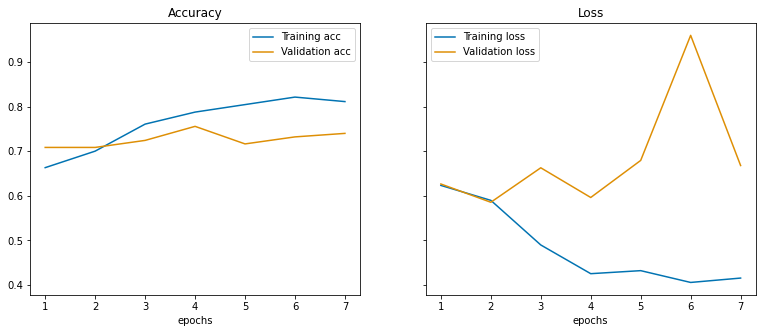

In [24]:
if multiple_gpus:
    with strategy.scope():
        model = HAN_opt(dl_config.embedding_matrix, dl_config, learning_rate=dl_config.learning_rate,
                                               seed_value=dl_config.seed_value)
else:
    model = HAN_opt(dl_config.embedding_matrix, dl_config, learning_rate=dl_config.learning_rate,
                                                seed_value=dl_config.seed_value)


history = model.fit(X_train, y_train,
                    epochs=dl_config.epochs,
                    batch_size=dl_config.batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=keras_callbacks)

if dl_config.keras_callbacks:
    model.load_weights(checkpoint_path)

train_loss, dl_config.train_acc = model.evaluate(X_train, y_train, verbose=0, batch_size = dl_config.batch_size)

print('Training Loss: %.3f' % (train_loss))
print('Training Accuracy: %.3f' % (dl_config.train_acc))

plot_training_history(history_dict=history, dl_config=dl_config)

In [25]:
x_test, y_test = DL_preprocessing(X_test_df, y_test_df, dl_config, dataset='test')

yhat_probs = model.predict(x_test, verbose=0)
yhat_probs = yhat_probs[:, 0]

yhat_classes = np.where(yhat_probs > 0.5, 1, yhat_probs)
yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)

Index of Unknown Words: 1


ROC AUC: 0.848009
Average Precision: 0.721673
Accuracy: 0.719780
Precision: 0.722222
Recall: 0.220339
F1 score: 0.337662
Confusion Matrix:
 [[118   5]
 [ 46  13]] 



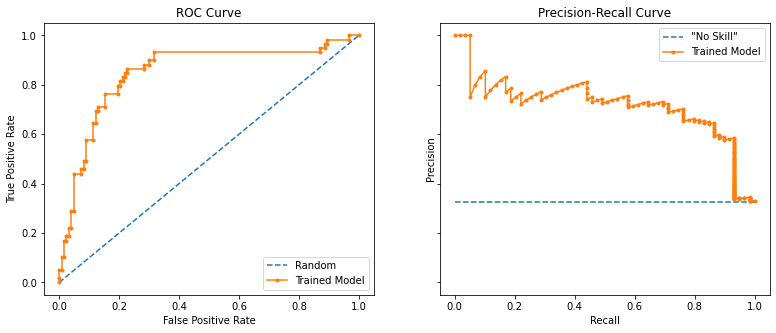

In [26]:
dl_config.test_roc_auc, dl_config.test_pr_auc = plot_roc_n_pr_curves(y_test, yhat_probs,dl_config = dl_config)
# ROC AUC
print('ROC AUC: %f' % dl_config.test_roc_auc)

# avg precision
dl_config.test_avg_prec = average_precision(y_test_df, yhat_probs)
print('Average Precision: %f' % dl_config.test_avg_prec)

# accuracy
dl_config.test_acc = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % dl_config.test_acc)

# precision tp / (tp + fp)
dl_config.test_prec = precision_score(y_test, yhat_classes)
print('Precision: %f' % dl_config.test_prec)

# recall: tp / (tp + fn)
dl_config.test_recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % dl_config.test_recall)

# f1: 2 tp / (2 tp + fp + fn)
dl_config.test_f1_score = f1_score(y_test, yhat_classes)
print('F1 score: %f' % dl_config.test_f1_score)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
matrix = np.flip(matrix)
print('Confusion Matrix:\n %s \n' % matrix)

<h3>
Hierarchical Attention LSTM
</h3>

In [27]:
"""Imports"""

from dl_models import Hierarchical_Attention_LSTM

In [28]:
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))

dl_config = DLConfig(remove_punctuation="HTML", stop_words=stops, lower=True, split_by_hyphen=True)

df = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                   index_col=0)
idsfinal = pandas_column_aslist(df, "Document")
docsfinal = pmids_to_docs(idsfinal, "pg42872@alunos.uminho.pt", dl_config)
docsfinal = docsfinal[0]
docsfinal[0].abstract_string
dataset_docs = docs_to_pandasdocs(docsfinal)

x_total = dataset_docs
print(x_total)

y_total = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                        index_col=1, usecols="B:F")

print(x_total)

relevance = pandas_column_aslist(y_total, "Relevance")
y_total = relevances_to_pandas(y_total, relevance)
print(y_total)

print(x_total["Document"][0].title_string)
print(x_total["Document"][0].abstract_string)

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(x_total, y_total, test_size=0.3, random_state=42,
                                                                stratify=y_total)
print(X_train_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_test_df.shape)

                                                   Document
25873669  <data_structures.document.Document object at 0...
24269870  <data_structures.document.Document object at 0...
17655245  <data_structures.document.Document object at 0...
16663649  <data_structures.document.Document object at 0...
33907682  <data_structures.document.Document object at 0...
...                                                     ...
32079399  <data_structures.document.Document object at 0...
26976595  <data_structures.document.Document object at 0...
20138774  <data_structures.document.Document object at 0...
27936616  <data_structures.document.Document object at 0...
28009095  <data_structures.document.Document object at 0...

[606 rows x 1 columns]
                                                   Document
25873669  <data_structures.document.Document object at 0...
24269870  <data_structures.document.Document object at 0...
17655245  <data_structures.document.Document object at 0...
16663649  <data_

In [29]:
model_name = "HA_LSTM"
dl_config = DLConfig(model_name=model_name, seed_value=seed_value)
dl_config.stop_words = stops
dl_config.lower = True
dl_config.remove_punctuation = False
dl_config.split_by_hyphen = True
dl_config.lemmatization = False
dl_config.stems = False

#Parameters
dl_config.padding = 'post'            #'pre' -> default; 'post' -> alternative
dl_config.truncating = 'post'         #'pre' -> default; 'post' -> alternative      #####
dl_config.oov_token = 'OOV'

dl_config.epochs = 50
dl_config.batch_size = 32     # e aumentar o batch
dl_config.learning_rate = 0.001   #experimentar diminuir

dl_config.max_sent_len = 50      #sentences will have a maximum of "max_sent_len" words    #400/500
dl_config.max_nb_words = 100_000      #it will only be considered the top "max_nb_words" words in the dataset
dl_config.max_nb_sentences = 15    # set only for the hierarchical attention model!!!

dl_config.embeddings = 'biowordvec'

# igual ao modelo anterior
dl_config.embedding_path = './embeddings/biowordvec'
dl_config.embedding_dim = 200
dl_config.embedding_format = 'word2vec'

dl_config.keras_callbacks = True

 # compara as losses d otrain e validation
if dl_config.keras_callbacks:
    dl_config.patience = 5   #early-stopping patience
    checkpoint_path = str(dl_config.model_id_path) + '\checkpoint.hdf5'
    keras_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=dl_config.patience),
           ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)  # guarda o modelo que tem a menor loss no validation
    ]
else:
    keras_callbacks = None


In [30]:
dl_config.tokenizer = text.Tokenizer(num_words=dl_config.max_nb_words, oov_token=dl_config.oov_token)

dl_config.validation_percentage = 30  # talvez aumentar
X_train, y_train, x_val, y_val = DL_preprocessing(X_train_df, y_train_df,
                                                  dl_config, dataset='train',
                                                  validation_percentage = dl_config.validation_percentage,
                                                  seed_value=dl_config.seed_value)
X_train[0][0]


Found 7907 unique tokens.
Index of Unknown Words: 1
Training set with 297 samples
Validation set with 127 samples


array([  22,    5,   20,  698, 1122, 3434,  178,   20,  698,  431,  497,
        333, 4734,  164,   86,    1,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0])

In [31]:
dl_config.embedding_matrix = compute_embedding_matrix(dl_config, embeddings_format = dl_config.embedding_format)
# quantas palavras encontrou no vocabulario do embedding

print(dl_config.embedding_matrix.shape)
print(dl_config.embedding_matrix)

Creating Embedding Matrix...
Embedding Matrix Created 
------------------------
number of null word embeddings: 350 in a total of 7907 words (4.43%)
words not found: 349
e.g. 10 words not found in the index :  ['hydroxyferuloyl' "'superior" "'jingzaojing" 'dk18' 'pholidotol'
 'dhs2001' '882000m' 'furtherstudy' 'metabolitism' 'piceides' '6β'
 'danfeng' 'myba2' 'sts36' 'spirotropis']
(7908, 200)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0848686  -0.0417668  -0.3709338  ...  0.07843895  0.08479623
   0.54163074]
 ...
 [ 0.15182443 -0.13880545  0.16630234 ... -0.29269406 -0.08847184
  -0.05204243]
 [-0.1121414  -0.08872321 -0.33860227 ... -0.34313729  0.25840917
  -0.20746794]
 [ 0.26528463  0.19522475 -0.05939044 ...  0.18617576 -0.05572284
  -0.12646711]]


In [32]:
if multiple_gpus:
    with strategy.scope():
        model = Hierarchical_Attention_LSTM(dl_config.embedding_matrix, dl_config, learning_rate=dl_config.learning_rate,
                                               seed_value=dl_config.seed_value)
else:
    model = Hierarchical_Attention_LSTM(dl_config.embedding_matrix, dl_config, learning_rate=dl_config.learning_rate,
                                                seed_value=dl_config.seed_value)


history = model.fit(X_train, y_train,
                    epochs=dl_config.epochs,
                    batch_size=dl_config.batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=keras_callbacks)

if dl_config.keras_callbacks:
    model.load_weights(checkpoint_path)

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
word_input (InputLayer)      [(None, 50)]              0         
_________________________________________________________________
word_embedding (Embedding)   (None, 50, 200)           1581600   
_________________________________________________________________
word_gru (Bidirectional)     (None, 50, 100)           100400    
_________________________________________________________________
word_dense (Dense)           (None, 50, 100)           10100     
_________________________________________________________________
word_attention (AttentionLay [(None, 100), (None, 50,  20400     
Total params: 1,712,500
Trainable params: 130,900
Non-trainable params: 1,581,600
_________________________________________________________________
None
Model: "model_5"
_________________________________________________________________
Layer (type)         

Index of Unknown Words: 1
ROC AUC: 0.857792
Average Precision: 0.748001
Accuracy: 0.686813
Precision: 0.750000
Recall: 0.050847
F1 score: 0.095238
Confusion Matrix:
 [[122   1]
 [ 56   3]] 



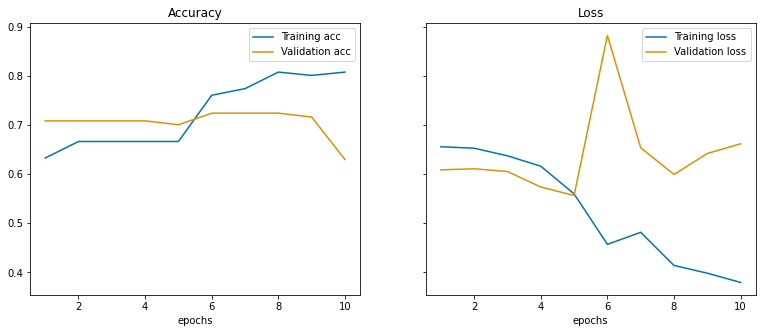

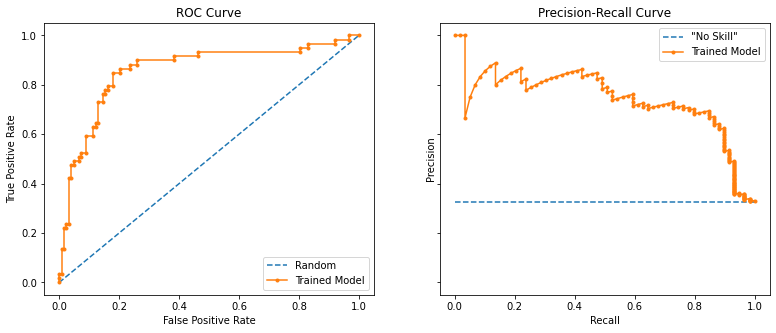

In [33]:
train_loss, dl_config.train_acc = model.evaluate(X_train, y_train, verbose=0, batch_size = dl_config.batch_size)
plot_training_history(history_dict=history, dl_config=dl_config)

x_test, y_test = DL_preprocessing(X_test_df, y_test_df, dl_config, dataset='test')

yhat_probs = model.predict(x_test, verbose=0)
yhat_probs = yhat_probs[:, 0]

yhat_classes = np.where(yhat_probs > 0.5, 1, yhat_probs)
yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)

dl_config.test_roc_auc, dl_config.test_pr_auc = plot_roc_n_pr_curves(y_test, yhat_probs, dl_config=dl_config)

# ROC AUC
print('ROC AUC: %f' % dl_config.test_roc_auc)

# avg precision
dl_config.test_avg_prec = average_precision(y_test_df, yhat_probs)
print('Average Precision: %f' % dl_config.test_avg_prec)

# accuracy
dl_config.test_acc = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % dl_config.test_acc)

# precision tp / (tp + fp)
dl_config.test_prec = precision_score(y_test, yhat_classes)
print('Precision: %f' % dl_config.test_prec)

# recall: tp / (tp + fn)
dl_config.test_recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % dl_config.test_recall)

# f1: 2 tp / (2 tp + fp + fn)
dl_config.test_f1_score = f1_score(y_test, yhat_classes)
print('F1 score: %f' % dl_config.test_f1_score)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
matrix = np.flip(matrix)
print('Confusion Matrix:\n %s \n' % matrix)

<h3>
Burns_CNNBiLSTM
</h3>

In [34]:
"""Imports"""

from dl_models import Burns_CNNBiLSTM

In [35]:
dl_config = DLConfig(remove_punctuation="HTML", stop_words=stops, lower=True, split_by_hyphen=False)

df = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                   index_col=0)
idsfinal = pandas_column_aslist(df, "Document")
docsfinal = pmids_to_docs(idsfinal, "pg42872@alunos.uminho.pt", dl_config)
docsfinal = docsfinal[0]
print(docsfinal[0].abstract_string)
dataset_docs = docs_to_pandasdocs(docsfinal)

x_total = dataset_docs
y_total = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                        index_col=1, usecols="B:F")  # os indices sao os IDs dos documentos

print(x_total)

relevance = pandas_column_aslist(y_total, "Relevance")
y_total = relevances_to_pandas(y_total, relevance)
print(y_total)

print(x_total["Document"][0].title_string)
print(x_total["Document"][0].abstract_string)

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(x_total, y_total, test_size=0.3, random_state=42,
                                                                stratify=y_total)
print(X_train_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_test_df.shape)

stilbenes , important secondary metabolites grapevine , represent central phytoalexins therefore constitute important element basal immunity . study , potential genetic variation vitis vinifera ssp . sylvestris , ancestor cultivated grapevine , sought respect output stilbenes potential use resistance breeding . considerable variation stilbene inducibility identified v. vinifera ssp . sylvestris . genotypic differences abundance profiles stilbenes induced response uv-c pulse shown . two clusters stilbene 'chemovars ' emerged : one cluster showed quick strong accumulation stilbenes , almost exclusively form non-glycosylated resveratrol viniferin , second cluster accumulated fewer stilbenes relatively high proportions piceatannol glycosylated piceid . 86 genotypes , time dependence stilbene pattern observed : piceid , resveratrol , piceatannol accumulated earlier , whereas viniferins found later . observed genotypic differences stilbene accumulation preceded differential accumulation tran

In [37]:
model_name = "BURNS"
dl_config = DLConfig(model_name=model_name, seed_value=seed_value)
dl_config.stop_words = stops
dl_config.lower = True
dl_config.remove_punctuation = False
dl_config.split_by_hyphen = False
dl_config.lemmatization = False
dl_config.stems = True

dl_config.padding = 'post'            #'pre' -> default; 'post' -> alternative
dl_config.truncating = 'post'         #'pre' -> default; 'post' -> alternative      #####
dl_config.oov_token = 'OOV'

dl_config.epochs = 50
dl_config.batch_size = 32     # e aumentar o batch
dl_config.learning_rate = 0.001   #experimentar diminuir

dl_config.max_sent_len = 300      #sentences will have a maximum of "max_sent_len" words    #400/500
dl_config.max_nb_words = 100_000      #it will only be considered the top "max_nb_words" words in the dataset

dl_config.embeddings = 'biowordvec'

dl_config.embedding_path = './embeddings/biowordvec'
dl_config.embedding_dim = 200
dl_config.embedding_format = 'word2vec'

dl_config.keras_callbacks = True

 # compara as losses d otrain e validation
if dl_config.keras_callbacks:
    dl_config.patience = 5   #early-stopping patience
    checkpoint_path = str(dl_config.model_id_path) + '\checkpoint.hdf5'
    keras_callbacks = [
            EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=dl_config.patience),
           ModelCheckpoint(checkpoint_path, monitor='val_loss', mode='min', verbose=1, save_best_only=True)  # guarda o modelo que tem a menor loss no validation
    ]
else:
    keras_callbacks = None

In [38]:
dl_config.tokenizer = text.Tokenizer(num_words=dl_config.max_nb_words, oov_token=dl_config.oov_token)

dl_config.validation_percentage = 30  # talvez aumentar
X_train, y_train, x_val, y_val = DL_preprocessing(X_train_df, y_train_df,
                                                  dl_config, dataset='train',
                                                  validation_percentage=dl_config.validation_percentage,
                                                  seed_value=dl_config.seed_value)
X_train[0][0]

Found 7907 unique tokens.
Training set with 297 samples
Validation set with 127 samples


22

In [39]:
dl_config.embedding_matrix = compute_embedding_matrix(dl_config, embeddings_format = dl_config.embedding_format)

print(dl_config.embedding_matrix.shape)
print(dl_config.embedding_matrix)


Creating Embedding Matrix...
Embedding Matrix Created 
------------------------
number of null word embeddings: 350 in a total of 7907 words (4.43%)
words not found: 349
e.g. 10 words not found in the index :  ['hydroxyferuloyl' "'superior" "'jingzaojing" 'dk18' 'pholidotol'
 'dhs2001' '882000m' 'furtherstudy' 'metabolitism' 'piceides' '6β'
 'danfeng' 'myba2' 'sts36' 'spirotropis']
(7908, 200)
[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [-0.0848686  -0.0417668  -0.3709338  ...  0.07843895  0.08479623
   0.54163074]
 ...
 [ 0.15182443 -0.13880545  0.16630234 ... -0.29269406 -0.08847184
  -0.05204243]
 [-0.1121414  -0.08872321 -0.33860227 ... -0.34313729  0.25840917
  -0.20746794]
 [ 0.26528463  0.19522475 -0.05939044 ...  0.18617576 -0.05572284
  -0.12646711]]


Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 300, 200)     1581600     input_5[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 300, 200)     0           embedding[0][0]                  
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 300, 16)      16016       dropout_1[0][0]                  
____________________________________________________________________________________________

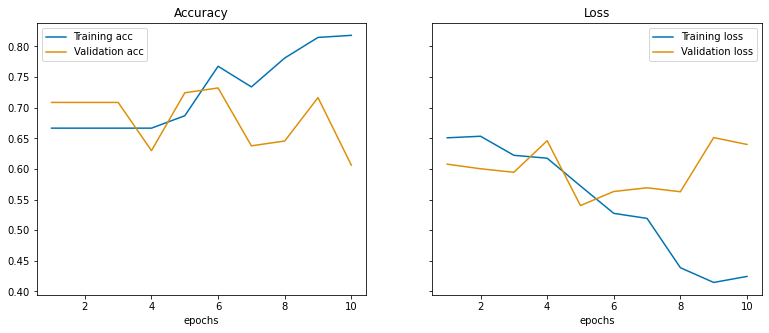

In [40]:
if multiple_gpus:
    with strategy.scope():
        model = Burns_CNNBiLSTM(dl_config.embedding_matrix, dl_config, learning_rate=dl_config.learning_rate,
                                               seed_value=dl_config.seed_value)
else:
    model = Burns_CNNBiLSTM(dl_config.embedding_matrix, dl_config, learning_rate=dl_config.learning_rate,
                                                seed_value=dl_config.seed_value)


history = model.fit(X_train, y_train,
                    epochs=dl_config.epochs,
                    batch_size=dl_config.batch_size,
                    validation_data=(x_val,y_val),
                    callbacks=keras_callbacks)

if dl_config.keras_callbacks:
    model.load_weights(checkpoint_path)

train_loss, dl_config.train_acc = model.evaluate(X_train, y_train, verbose=0)

print('Training Loss: %.3f' % (train_loss))
print('Training Accuracy: %.3f' % (dl_config.train_acc))

plot_training_history(history_dict = history, dl_config=dl_config)

x_test, y_test = DL_preprocessing(X_test_df, y_test_df, dl_config, dataset='test')

yhat_probs = model.predict(x_test, verbose=0)
yhat_probs = yhat_probs[:, 0]

yhat_classes = np.where(yhat_probs > 0.5, 1, yhat_probs)
yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)

ROC AUC: 0.853521
Average Precision: 0.696908
Accuracy: 0.725275
Precision: 0.736842
Recall: 0.237288
F1 score: 0.358974
Confusion Matrix:
 [[118   5]
 [ 45  14]] 



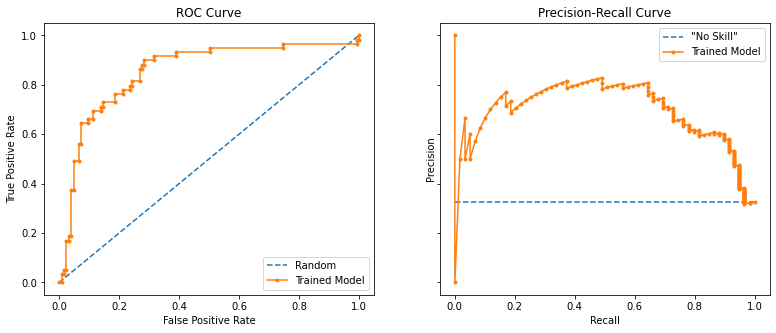

In [41]:
dl_config.test_roc_auc, dl_config.test_pr_auc = plot_roc_n_pr_curves(y_test, yhat_probs, dl_config=dl_config)

# ROC AUC
print('ROC AUC: %f' % dl_config.test_roc_auc)

# avg precision
dl_config.test_avg_prec = average_precision(y_test_df, yhat_probs)
print('Average Precision: %f' % dl_config.test_avg_prec)

# accuracy
dl_config.test_acc = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % dl_config.test_acc)

# precision tp / (tp + fp)
dl_config.test_prec = precision_score(y_test, yhat_classes)
print('Precision: %f' % dl_config.test_prec)

# recall: tp / (tp + fn)
dl_config.test_recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % dl_config.test_recall)

# f1: 2 tp / (2 tp + fp + fn)
dl_config.test_f1_score = f1_score(y_test, yhat_classes)
print('F1 score: %f' % dl_config.test_f1_score)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
matrix = np.flip(matrix)
print('Confusion Matrix:\n %s \n' % matrix)


<h3>
BioBert_LSTM
</h3>

In [13]:
seed_value = 42
model_name = "Bert_LSTM"
np.random.seed(seed_value)
random.seed(seed_value)
tensorflow.random.set_seed(seed_value)
print(sys.executable)

import torch
if seed_value:
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
os.environ['PYTHONHASHSEED'] = str(seed_value)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

if multiple_gpus:
    devices = []
    for gpu in multiple_gpus:
        devices.append('/gpu:' + str(gpu))
    strategy = tensorflow.distribute.MirroredStrategy(devices=devices)
    os.environ["CUDA_VISIBLE_DEVICES"] = ''

else:
    # Get the GPU device name.
    device_name = tensorflow.test.gpu_device_name()
    # The device name should look like the following:
    if device_name == '/device:GPU:0':
        print('Using GPU: {}'.format(device_name))
    else:
        raise SystemError('GPU device not found')

    os.environ["CUDA_VISIBLE_DEVICES"] = device_name
    os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"


C:\ProgramData\Anaconda3\python.exe
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [14]:
"""Imports"""

from dl import Bert_preprocessing
from dl_models import Bert_LSTM
from transformers import BertTokenizer

os.environ["WANDB_API_KEY"] = "0" ## to silence warning
!transformers-cli convert --model_type bert \
  --tf_checkpoint "C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/biobert_v1.1_pubmed/model.ckpt-1000000" \
  --config "C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/biobert_v1.1_pubmed/bert_config.json" \
  --pytorch_dump_output "C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/biobert_v1.1_pubmed/pytorch_model.bin"

Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.6.1",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

Save PyTorch model to C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/biobert_v1.1_pubmed/pytorch_model.bin


2021-06-22 19:00:48.749461: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'cudart64_110.dll'; dlerror: cudart64_110.dll not found
2021-06-22 19:00:48.749592: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
Converting TensorFlow checkpoint from C:\Users\Zé Freitas\Desktop\Mestrado\2ºSemestre\Projeto\code\biobert_v1.1_pubmed\model.ckpt-1000000
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight bert/embeddings/LayerNorm/gamma with shape [768]
Loading TF weight bert/embeddings/position_embeddings with shape [512, 768]
Loading TF weight bert/embeddings/token_type_embeddings with shape [2, 768]
Loading TF weight bert/embeddings/word_embeddings with shape [28996, 768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/beta with shape [768]
Loading TF weight bert/encoder/layer_0/attention/output/LayerNorm/gamma with s

In [17]:
def pandas_column_aslist(dataframe, column):
    lst = dataframe[column].tolist()
    return lst  # lista de strings

def relevances_to_pandas(dataframe, relevances):
    indexes = list(dataframe.index.values)
    labels = []
    for r in relevances:
        if r == "not relevant":
            labels.append(0)
        elif r == "relevant":
            labels.append(1)
    return pandas.Series(labels, index=indexes, name='Label')

dl_config = DLConfig(remove_punctuation="HTML")

df = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                   index_col=0)
idsfinal = pandas_column_aslist(df, "Document")
docsfinal = pmids_to_docs(idsfinal, "pg42872@alunos.uminho.pt", dl_config)
docsfinal = docsfinal[0]
print(docsfinal[0].abstract_string)
dataset_docs = docs_to_pandasdocs(docsfinal)

x_total = dataset_docs
print(x_total)

y_total = pandas.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                        index_col=1, usecols="B:F")

print(x_total)

relevance = pandas_column_aslist(y_total, "Relevance")
y_total = relevances_to_pandas(y_total, relevance)
print(y_total)

print(x_total["Document"][0].title_string)
print(x_total["Document"][0].abstract_string)

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(x_total, y_total, test_size=0.3, random_state=42,
                                                                stratify=y_total)
print(X_train_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_test_df.shape)

Stilbenes , as important secondary metabolites of grapevine , represent central phytoalexins and therefore constitute an important element of basal immunity . In this study , potential genetic variation in Vitis vinifera ssp . sylvestris , the ancestor of cultivated grapevine , was sought with respect to their output of stilbenes and potential use for resistance breeding . Considerable variation in stilbene inducibility was identified in V. vinifera ssp . sylvestris . Genotypic differences in abundance and profiles of stilbenes that are induced in response to a UV-C pulse are shown . Two clusters of stilbene 'chemovars ' emerged : one cluster showed quick and strong accumulation of stilbenes , almost exclusively in the form of non-glycosylated resveratrol and viniferin , while the second cluster accumulated fewer stilbenes and relatively high proportions of piceatannol and the glycosylated piceid . For all 86 genotypes , a time dependence of the stilbene pattern was observed : piceid ,

In [18]:
dl_config = DLConfig(model_name=model_name, seed_value=seed_value)

dl_config.stop_words = None
dl_config.lower = False                #####
dl_config.remove_punctuation = False
dl_config.split_by_hyphen = False
dl_config.lemmatization = False           #####
dl_config.stems = False

#Parameters
dl_config.padding = 'post'
dl_config.truncating = 'post'

dl_config.epochs = 2     # recommended number of epochs: 2, 3, 4
dl_config.batch_size = 16    # recommended batch-size: 16 or 32  # 8, 16, 32, 64, 128
dl_config.learning_rate =  3e-5# recommended learning rate for Adam: 5e-5, 3e-5, 2e-5   # 3e-4, 1e-4,

dl_config.max_sent_len = 512      #sentences will have a maximum of "max_sent_len" words
dl_config.nmr_sentences = 1   #[1 or 2]

dl_config.validation_percentage = 30

In [19]:
dl_config.keras_callbacks = True

if dl_config.keras_callbacks:
    checkpoint_path = str(dl_config.model_id_path) + "/model.{epoch:02d}.h5"
    keras_callbacks = [
            ModelCheckpoint(checkpoint_path,
                            verbose=0,
                            save_best_only=False,
                            save_weights_only=True,
                           save_freq='epoch')
    ]

else:
    keras_callbacks=None


In [20]:
dl_config.tokenizer = BertTokenizer.from_pretrained('biobert_v1.1_pubmed', do_lower_case=False)

x_train, y_train, x_val, y_val =  Bert_preprocessing(X_train_df, y_train_df,
                                                     dl_config,
                                                     nmr_sentences = dl_config.nmr_sentences,
                                                     validation_percentage = dl_config.validation_percentage,
                                                     seed_value=dl_config.seed_value)

Training set with 297 samples
Validation set with 127 samples


In [ ]:
biobert_path = './biobert_v1.1_pubmed'
if multiple_gpus:
    with strategy.scope():
        #model = Bert_FT(dl_config, learning_rate=dl_config.learning_rate, bert_name_or_path=biobert_path, bert_config=True)
        model = Bert_LSTM(dl_config, learning_rate=dl_config.learning_rate,static_bert=False, bert_name_or_path=biobert_path, bert_config=True)

else:
    #model = Bert_FT(dl_config, learning_rate=dl_config.learning_rate, bert_name_or_path=biobert_path, bert_config=True)
    model = Bert_LSTM(dl_config, learning_rate=dl_config.learning_rate,static_bert=False, bert_name_or_path=biobert_path, bert_config=True)

history = model.fit(x_train, y_train,
                    epochs=dl_config.epochs,
                    batch_size=dl_config.batch_size,
                    validation_data=(x_val, y_val),
                    callbacks=keras_callbacks)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'bert.embeddings.position_ids', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_idx (InputLayer)          [(None, 512)]

In [ ]:
plot_training_history(history_dict = history, dl_config=dl_config)


x_test, y_test = Bert_preprocessing(X_test_df, y_test_df, dl_config,
                                    nmr_sentences=dl_config.nmr_sentences)

yhat_probs = model.predict(x_test, verbose=0)
yhat_probs = yhat_probs[:, 0]

yhat_classes = np.where(yhat_probs > 0.5, 1, yhat_probs)
yhat_classes = np.where(yhat_classes < 0.5, 0, yhat_classes).astype(np.int64)

In [ ]:
dl_config.test_roc_auc, dl_config.test_pr_auc = plot_roc_n_pr_curves(y_test, yhat_probs, dl_config=dl_config)

# ROC AUC
print('ROC AUC: %f' % dl_config.test_roc_auc)

# avg precision
dl_config.test_avg_prec = average_precision(y_test_df, yhat_probs)
print('Average Precision: %f' % dl_config.test_avg_prec)

# accuracy
dl_config.test_acc = accuracy_score(y_test, yhat_classes)
print('Accuracy: %f' % dl_config.test_acc)

# precision tp / (tp + fp)
dl_config.test_prec = precision_score(y_test, yhat_classes)
print('Precision: %f' % dl_config.test_prec)

# recall: tp / (tp + fn)
dl_config.test_recall = recall_score(y_test, yhat_classes)
print('Recall: %f' % dl_config.test_recall)

# f1: 2 tp / (2 tp + fp + fn)
dl_config.test_f1_score = f1_score(y_test, yhat_classes)
print('F1 score: %f' % dl_config.test_f1_score)

# confusion matrix
matrix = confusion_matrix(y_test, yhat_classes)
matrix = np.flip(matrix)
print('Confusion Matrix:\n %s \n' % matrix)

<h2>
Supervised Machine Learning
</h2>
<h3>
TF-IDF
</h3>

In [2]:
"""Imports"""

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_validate
import pandas as pd
import numpy as np
from dl_config import DLConfig
from ml_features_generator import generate_features_dr
from wrappers.pandas_wrapper import pandas_column_aslist, relevances_to_pandas, docs_to_pandasdocs
from web_pubmed_reader import pmids_to_docs
from nltk.corpus import stopwords
stops = set(stopwords.words("english"))
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score,\
    precision_recall_curve, recall_score, average_precision_score

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Zé Freitas\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to C:\Users\Zé
[nltk_data]     Freitas\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Zé
[nltk_data]     Freitas\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Zé
[nltk_data]     Freitas\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
vectorizer_w_stops = TfidfVectorizer(stop_words=stops)

dl_config = DLConfig()

df = pd.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                   index_col=0, usecols="A:F")  # dataset que foi criado sem nenhum processamento
idsfinal = pandas_column_aslist(df, "Document")
docsfinal = pmids_to_docs(idsfinal, "pg42872@alunos.uminho.pt", dl_config)
docsfinal = docsfinal[0]
dataset_docs = docs_to_pandasdocs(docsfinal)

abst = pandas_column_aslist(df, "Abstract")
len(abst)
print(abst[0])
X = vectorizer_w_stops.fit_transform(abst)
print(X)
print(X.shape)

print(vectorizer_w_stops.get_feature_names())
print(len(vectorizer_w_stops.get_feature_names()))
analyser = vectorizer_w_stops.build_analyzer()
print(analyser(abst[0]))

Stilbenes , as important secondary metabolites of grapevine , represent central phytoalexins and therefore constitute an important element of basal immunity . In this study , potential genetic variation in Vitis vinifera ssp . sylvestris , the ancestor of cultivated grapevine , was sought with respect to their output of stilbenes and potential use for resistance breeding . Considerable variation in stilbene inducibility was identified in V. vinifera ssp . sylvestris . Genotypic differences in abundance and profiles of stilbenes that are induced in response to a UV-C pulse are shown . Two clusters of stilbene 'chemovars ' emerged : one cluster showed quick and strong accumulation of stilbenes , almost exclusively in the form of non-glycosylated resveratrol and viniferin , while the second cluster accumulated fewer stilbenes and relatively high proportions of piceatannol and the glycosylated piceid . For all 86 genotypes , a time dependence of the stilbene pattern was observed : piceid ,

<p>

</p>

In [4]:
y_total = pd.read_excel("C:/Users/Zé Freitas/Desktop/Mestrado/2ºSemestre/Projeto/code/datasets/dataset_final.xlsx",
                        index_col=1, usecols="B:F")

relevance = pandas_column_aslist(y_total, "Relevance")
y_total = relevances_to_pandas(y_total, relevance)
print(y_total)

# as variáveis de entrada serão os scores das features (matriz de tfidf)
X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(X, y_total, test_size=0.3, random_state=42,
                                                                stratify=y_total)
print(X_train_df.shape)
print(X_test_df.shape)
print(y_train_df.shape)
print(y_test_df.shape)

25873669    0
24269870    0
17655245    1
16663649    1
33907682    0
           ..
32079399    1
26976595    0
20138774    1
27936616    1
28009095    1
Name: Label, Length: 606, dtype: int64
(424, 9403)
(182, 9403)
(424,)
(182,)


<p>
Os <strong>DataFrames de treino</strong> criados contêm, nas linhas, os documentos,
e nas colunas todas as features geradas anteriormente pelo processo de <strong>
TF-IDF</strong>. Este DataFrame é muito desproporcional em termos de número de linhas
e número de colunas, pelo que a melhor opção será reduzir o número de colunas de modo
a evitar o over-fiting do modelo (meter descrição). <br>
Tendo isso em contra, foi utilizado o package <strong>RFE</strong> do sklearn, que permite
realizar feature selection de acordo com os melhores scores da matriz gerada a cima.
</p>

In [5]:
estimator = SVC(kernel= "linear")
selector = RFE(estimator, n_features_to_select=300, step=1)
selector_norm = selector.fit(X_train_df, y_train_df)

<p>
A pipeline da célula anterior permite realizar, em primero lugar, uma standardização dos
dados da matriz de frequências de termos por documento, e dizer ao mesmo tempo qual o
modelo SVM que vai ser utilizado. <br>
Ao passar este estimador para a função RFE, podemos escolher o número de features que
queremos que sejam selecionadas, neste caso, como este dataset tem 606 linhas (Documentos)
ficou decidido selecionar apenas as 300 melhores features.
</p>
<p>
A seguir passamos inevitavelmente para a predição da relevância dos documentos presentes no
test_set.
</p>

In [11]:
pred = selector_norm.predict(X_test_df)
selector_norm.score(X_test_df, y_test_df)

array([[114,   9],
       [ 25,  34]], dtype=int64)

In [ ]:
cm = confusion_matrix(y_test_df, pred)
cm = np.flip(cm)
print(cm)

acc = accuracy_score(y_test_df, pred)
print(acc)  # é igual ao método .score()

prec = precision_score(y_test_df, pred)
print(prec)

rec = recall_score(y_test_df, pred)
print(rec)

In [ ]:
# Cross Validation
scores = cross_validate(selector_norm, X, y_total, cv=5, scoring=("accuracy", "precision", "recall", "f1"))

print(scores["test_accuracy"])
print(scores["test_precision"])
print(scores["test_recall"])
print(scores["test_f1"])

In [ ]:
matrix = confusion_matrix(y_test_df.values, pred)
print(matrix)

<p>
Para os dados standardizados:
</p>

In [12]:
scaler = StandardScaler(with_mean=False)  # nao pode usar a média por ser sparse matrix
scaler.fit(X)
X_scaled = scaler.transform(X)
print(X_scaled)  # matriz de TF-IDFs strandardizada

# Divisão em train e test
X_train_df_scaled, X_test_df_scaled, y_train_df, y_test_df = train_test_split(X_scaled, y_total, test_size=0.3,
                                                                              random_state=42, stratify=y_total)
print(X_train_df_scaled.shape)
print(X_test_df_scaled.shape)
print(y_train_df.shape)
print(y_test_df.shape)

selector = RFE(estimator, n_features_to_select=300, step=1)
selector_scaled = selector.fit(X_train_df_scaled, y_train_df)

pred_scaled = selector.predict(X_test_df_scaled)
selector_scaled.score(X_test_df, y_test_df)

matrix = confusion_matrix(y_test_df.values, pred_scaled)
print(matrix)

  (0, 6290)	2.0855101269787246
  (0, 2294)	5.046915214520747
  (0, 2320)	2.540524587697452
  (0, 7396)	6.593205052025273
  (0, 5112)	2.079495968996465
  (0, 2071)	2.2275908813912486
  (0, 8360)	4.347418808530979
  (0, 4985)	3.3052758971804423
  (0, 7885)	2.1164774459151747
  (0, 8257)	24.637403533906777
  (0, 9030)	14.159581400419084
  (0, 7501)	2.5752497541527446
  (0, 9148)	2.2683605901527204
  (0, 6624)	4.278739955210288
  (0, 5492)	2.9271603949145586
  (0, 3009)	4.678351574202174
  (0, 8359)	7.296720701472103
  (0, 6730)	5.548153735433048
  (0, 7731)	15.250471933293142
  (0, 7623)	1.8389176699125274
  (0, 8230)	5.695532441234388
  (0, 6216)	4.444652191346603
  (0, 5142)	3.7786302714815663
  (0, 795)	11.166037776156353
  (0, 6468)	3.5847344761535846
  :	:
  (605, 9017)	4.258386510359176
  (605, 4495)	4.385817297292112
  (605, 1771)	1.0311604843675872
  (605, 2525)	3.102026903971881
  (605, 1409)	2.362185837958699
  (605, 5949)	4.377106317082512
  (605, 8320)	3.163558391796091
  (605

<p>
Em modelos de SVM é, numa grande maioria das vezes, aconselhada a standardização dos dados, devido
à forma como o modelo atua, e por isso, esta passo foi também incluído, usando a função <i>StandardScaler
</i> do sklearn, a matriz <i>term-document</i> fruto do processo <strong> TF-IFD</strong>, foi standardizada
segundo apenas o seu desvio padrão, uma vez que se trato de uma <i>Sparse Matrix</i>, ou seja, é uma matriz
composta essencialmente por elementos nulos.
Os dados standardizadas revelaram um declínio bastante acentuado no valor de score (mean accuracy), pelo que
se pode concluir que não se deve proceder a standardização dos dados.
</p>


<p>
<strong> Conclusões no paper!</strong>
</p>

